<a href="https://colab.research.google.com/github/sidsaucersupreme/Predicting-the-Thermodynamic-Stability-of-Perovskite-Oxides-Using-Machine-Learning-Models/blob/main/die_detection_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Verify NVIDIA GPU Availability**

Make sure you're using a GPU-equipped machine by going to "Runtime" -> "Change runtime type" in the top menu bar, and then selecting one of the GPU options in the Hardware accelerator section. Click Play on the following code block to verify that the NVIDIA GPU is present and ready for training.

In [ ]:
!nvidia-smi

Fri Jul 18 08:08:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Next, we'll upload our dataset and prepare it for training with YOLO. We'll split the dataset into train and validation folders, and we'll automatically generate the configuration file for training the model.

## 2.1 Upload images

First, we need to upload the dataset to Colab. Here are a few options for moving the `data.zip` folder into this Colab instance.

**Option 1. Upload through Google Colab**

Upload the `data.zip` file to the Google Colab instance by clicking the "Files" icon on the left hand side of the browser, and then the "Upload to session storage" icon. Select the zip folder to upload it.

<p>
<br>
<img src="https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/doc/upload-colab-files.png" height="240">
</p>


In [ ]:
"""from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/path/to/data.zip /content"""

## 2.2 Split images into train and validation folders

In [ ]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

In [ ]:
!pip install albumentations opencv-python numpy

Given a small dataset we can extrapolate to increase training data

In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
from pathlib import Path

# Define paths
data_dir = "/content/custom_data"  # Replace with your dataset path
images_dir = os.path.join(data_dir, "images")
labels_dir = os.path.join(data_dir, "labels")
output_images_dir = os.path.join(data_dir, "augmented_images")
output_labels_dir = os.path.join(data_dir, "augmented_labels")

# Create output directories
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# Define augmentation pipeline
augmentation_pipeline = A.Compose([
    A.Rotate(limit=15, p=0.5),  # Rotate by ±15 degrees
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HorizontalFlip(p=0.5),  # Horizontal flip
    A.Affine(scale=(0.9, 1.1), p=0.3),  # Slight zoom
    A.GaussNoise(p=0.3),  # Add noise
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Function to read YOLO labels
def read_yolo_labels(label_path):
    bboxes = []
    class_labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:  # class_id, center_x, center_y, width, height
                    class_id, x, y, w, h = map(float, parts)
                    bboxes.append([x, y, w, h])
                    class_labels.append(int(class_id))
    return bboxes, class_labels

# Function to save YOLO labels
def save_yolo_labels(label_path, bboxes, class_labels):
    with open(label_path, 'w') as f:
        for bbox, cls in zip(bboxes, class_labels):
            f.write(f"{cls} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

# Augmentation loop
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
target_count = 1000
augmentations_per_image = max(1, (target_count // len(image_files)) + 1)

for image_file in image_files:
    # Load image
    image_path = os.path.join(images_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Load corresponding label
    label_file = os.path.splitext(image_file)[0] + '.txt'
    label_path = os.path.join(labels_dir, label_file)
    bboxes, class_labels = read_yolo_labels(label_path)

    # Generate augmented images
    for i in range(augmentations_per_image):
        # Apply augmentation
        augmented = augmentation_pipeline(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_class_labels = augmented['class_labels']

        # Save augmented image
        aug_image_file = f"{os.path.splitext(image_file)[0]}_aug_{i}.jpg"
        aug_image_path = os.path.join(output_images_dir, aug_image_file)
        cv2.imwrite(aug_image_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

        # Save augmented labels
        aug_label_file = f"{os.path.splitext(image_file)[0]}_aug_{i}.txt"
        aug_label_path = os.path.join(output_labels_dir, aug_label_file)
        save_yolo_labels(aug_label_path, aug_bboxes, aug_class_labels)

# Copy classes.txt and notes.json to the output directory
import shutil
shutil.copy(os.path.join(data_dir, "classes.txt"), output_images_dir)
shutil.copy(os.path.join(data_dir, "notes.json"), output_images_dir)

print(f"Augmentation complete. Check {output_images_dir} and {output_labels_dir} for results.")

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Augmentation complete. Check /content/custom_data/augmented_images and /content/custom_data/augmented_labels for results.


In [ ]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.98

--2025-07-18 08:08:12--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-07-18 08:08:12 (56.5 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 177
Number of annotation files: 177
Images moving to train: 173
Images moving to validation: 4


In [ ]:
import os
import shutil
import random

# --- Configuration ---
dataset_dir = '/content/custom_data'  # Original dataset directory
images_dir = os.path.join(dataset_dir, '/content/custom_data/augmented_images')  # Images folder
labels_dir = os.path.join(dataset_dir, '/content/custom_data/augmented_labels')  # Labels folder

output_dir = 'split_dataset'  # Output folder
train_ratio = 0.8  # 80% training, 20% validation

# --- Create output directories ---
train_images = os.path.join(output_dir, 'train', 'images')
train_labels = os.path.join(output_dir, 'train', 'labels')
val_images = os.path.join(output_dir, 'val', 'images')
val_labels = os.path.join(output_dir, 'val', 'labels')

for d in [train_images, train_labels, val_images, val_labels]:
    os.makedirs(d, exist_ok=True)

# --- Get all image files ---
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# --- Shuffle and split ---
random.shuffle(image_files)
split_idx = int(len(image_files) * train_ratio)
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

# --- Copy files ---
def copy_files(file_list, target_images_dir, target_labels_dir):
    for image_file in file_list:
        label_file = os.path.splitext(image_file)[0] + '.txt'

        src_image = os.path.join(images_dir, image_file)
        src_label = os.path.join(labels_dir, label_file)

        dst_image = os.path.join(target_images_dir, image_file)
        dst_label = os.path.join(target_labels_dir, label_file)

        shutil.copy2(src_image, dst_image)
        if os.path.exists(src_label):
            shutil.copy2(src_label, dst_label)

copy_files(train_files, train_images, train_labels)
copy_files(val_files, val_images, val_labels)

print(f"Dataset split complete. {len(train_files)} training images, {len(val_files)} validation images.")


Dataset split complete. 800 training images, 201 validation images.


# 3.&nbsp;Install Requirements (Ultralytics)

Next, we'll install the Ultralytics library in this Google Colab instance. This Python library will be used to train the YOLO model.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

# 4.&nbsp;Configure Training


In [ ]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 1
names:
- dies


In [ ]:
import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml, dataset_root):

    # Read classes.txt
    if not os.path.exists(path_to_classes_txt):
        print(f'classes.txt not found! Please create it at {path_to_classes_txt}')
        return

    with open(path_to_classes_txt, 'r') as f:
        classes = [line.strip() for line in f if line.strip()]
    number_of_classes = len(classes)

    # Compose dictionary
    data = {
        'path': '/content/split_dataset',                 # 👈 New: use the folder you want
        'train': 'train/images',
        'val': 'val/images',                  # Usually 'val', not 'validation'
        'nc': number_of_classes,
        'names': classes
    }

    with open(path_to_data_yaml, 'w') as f:
        yaml.dump(data, f, sort_keys=False)

    print(f'✅ Created: {path_to_data_yaml}\n')
    return

# Usage:
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'
dataset_root = '/content/split_dataset'   # 👈 point here!

create_data_yaml(path_to_classes_txt, path_to_data_yaml, dataset_root)

# Check output
print('\n--- File contents: ---\n')
!cat /content/data.yaml


✅ Created: /content/data.yaml


--- File contents: ---

path: /content/split_dataset
train: train/images
val: val/images
nc: 1
names:
- dies


# 5.&nbsp;Train Model

## 5.1 Training Parameters
Now that the data is organized and the config file is created, we're ready to start training! First, there are a few important parameters to decide on. Visit my article on [Training YOLO Models Locally](https://www.ejtech.io/learn/train-yolo-models) to learn more about these parameters and how to choose them.

**Model architecture & size (`model`):**

There are several YOLO11 models sizes available to train, including `yolo11n.pt`, `yolo11s.pt`, `yolo11m.pt`, `yolo11l.pt`, and `yolo11xl.pt`. Larger models run slower but have higher accuracy, while smaller models run faster but have lower accuracy. I made a brief YouTube video that compares performance of different YOLO models on a Raspberry Pi 5 and a laptop with a RTX 4050 GPU, [check it out here to get a sense of their speed accuracy](https://youtu.be/_WKS4E9SmkA). If you aren't sure which model size to use, `yolo11s.pt` is a good starting point.

You can also train YOLOv8 or YOLOv5 models by substituting `yolo11` for `yolov8` or `yolov5`.


**Number of epochs (`epochs`)**

In machine learning, one “epoch” is one single pass through the full training dataset. Setting the number of epochs dictates how long the model will train for. The best amount of epochs to use depends on the size of the dataset and the model architecture. If your dataset has less than 200 images, a good starting point is 60 epochs. If your dataset has more than 200 images, a good starting point is 40 epochs.


**Resolution (`imgsz`)**

Resolution has a large impact on the speed and accuracy of the model: a lower resolution model will have higher speed but less accuracy. YOLO models are typically trained and inferenced at a 640x640 resolution. However, if you want your model to run faster or know you will be working with low-resolution images, try using a lower resolution like 480x480.


## 5.2 Run Training!

Run the following code block to begin training. If you want to use a different model, number of epochs, or resolution, change `model`, `epochs`, or `imgsz`.

In [ ]:
from ultralytics import YOLO

# Load the YOLOv8s model (make sure the filename is correct, likely 'yolov8s.pt')
model = YOLO("yolo11s.pt")

# Train the model
model.train(
    data="/content/data.yaml",  # Path to dataset YAML
    epochs=26,                  # Number of training epochs
    imgsz=640,                  # Image size
    task="detect"              # Detection task

)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 18.4M/18.4M [00:00<00:00, 341MB/s]


Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=26, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

100%|██████████| 755k/755k [00:00<00:00, 104MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    443776  ultralytics.nn.modules.block.C3k2            [768, 256, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    127680  ultralytics.nn.modules.block.C3k2            [512,

100%|██████████| 5.35M/5.35M [00:00<00:00, 381MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 72.2±29.8 MB/s, size: 327.9 KB)


train: Scanning /content/data/train/labels... 173 images, 0 backgrounds, 0 corrupt: 100%|██████████| 173/173 [00:00<00:00, 313.15it/s]

train: New cache created: /content/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 76.1±16.1 MB/s, size: 338.9 KB)


val: Scanning /content/data/validation/labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 4429.04it/s]

val: New cache created: /content/data/validation/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 26 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/26      4.03G      1.547      2.589      1.541        318        640: 100%|██████████| 11/11 [00:09<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

                   all          4         51      0.628      0.663      0.695      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/26      4.34G       1.41      1.293      1.296        212        640: 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all          4         51      0.755      0.725      0.755      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/26      4.38G      1.401      1.103      1.267        274        640: 100%|██████████| 11/11 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all          4         51      0.844      0.706      0.783      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/26      4.42G      1.353       1.02      1.259        227        640: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all          4         51      0.716      0.392      0.444      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/26      4.46G      1.339     0.9978      1.254        265        640: 100%|██████████| 11/11 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

                   all          4         51      0.218      0.353      0.141       0.08



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/26       4.5G      1.328     0.9694      1.257        133        640: 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

                   all          4         51     0.0215     0.0784    0.00836    0.00553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/26      4.54G      1.301     0.8426      1.211        222        640: 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all          4         51     0.0113      0.176    0.00562    0.00314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/26      4.58G      1.328     0.8791       1.23        202        640: 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all          4         51      0.682      0.627      0.648      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/26      4.62G      1.289     0.8242      1.218        316        640: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


                   all          4         51      0.923      0.703      0.784      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/26      4.66G      1.302     0.8227      1.207        327        640: 100%|██████████| 11/11 [00:03<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all          4         51      0.771      0.745      0.774      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/26       4.7G      1.265     0.8262      1.211        188        640: 100%|██████████| 11/11 [00:04<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


                   all          4         51       0.92      0.549       0.66      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/26      4.74G      1.253     0.8057      1.186        200        640: 100%|██████████| 11/11 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


                   all          4         51        0.9      0.843      0.872      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/26      4.78G      1.251     0.7835      1.187        322        640: 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all          4         51      0.935      0.841      0.867      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/26         5G      1.253      0.801      1.193        185        640: 100%|██████████| 11/11 [00:03<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all          4         51      0.771      0.793      0.796      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/26      5.04G      1.211     0.7394      1.174        239        640: 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all          4         51      0.975      0.824      0.905      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/26      5.08G       1.19     0.7362      1.154        245        640: 100%|██████████| 11/11 [00:03<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all          4         51      0.912      0.816      0.902      0.593


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/26      5.12G      1.182     0.7417      1.177        129        640: 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all          4         51       0.86      0.765      0.818      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/26      5.16G      1.161     0.7151      1.166        126        640: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all          4         51      0.893      0.843      0.893      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/26       5.2G      1.149     0.7346      1.155         84        640: 100%|██████████| 11/11 [00:03<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all          4         51      0.877      0.842       0.89      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/26      5.24G      1.145      0.679      1.144        157        640: 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


                   all          4         51      0.913      0.819      0.895      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/26      5.28G      1.145     0.6609      1.144        142        640: 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

                   all          4         51      0.934      0.824      0.899      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/26      5.32G      1.111      0.642       1.13        143        640: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all          4         51      0.977      0.836      0.911      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/26      5.36G      1.095     0.6437      1.119        168        640: 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all          4         51      0.955      0.835      0.914      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/26       5.4G      1.069     0.6058      1.112        128        640: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all          4         51      0.977      0.822      0.909      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/26      5.44G      1.053     0.5985      1.098        143        640: 100%|██████████| 11/11 [00:05<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all          4         51      0.977      0.823      0.913      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/26      5.47G      1.058     0.5866      1.111        105        640: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all          4         51      0.936      0.856      0.917       0.63



26 epochs completed in 0.046 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.18it/s]


                   all          4         51      0.977      0.836      0.911      0.634
Speed: 0.3ms preprocess, 6.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7962b01ea350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
#!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=2 imgsz=640

#6.&nbsp;Test Model

The model has been trained; now it's time to test it! The commands below run the model on the images in the validation folder and then display the results.


In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True conf=0.55



Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/4 /content/data/validation/images/0f5ddbc2-die_107.jpg: 640x480 5 diess, 52.4ms
image 2/4 /content/data/validation/images/4ecde482-die_52.jpeg: 640x480 16 diess, 12.4ms
image 3/4 /content/data/validation/images/b356d967-die_132.jpeg: 640x480 11 diess, 12.4ms
image 4/4 /content/data/validation/images/f6347e55-die_159.jpeg: 640x480 10 diess, 12.4ms
Speed: 3.1ms preprocess, 22.4ms inference, 46.6ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
#!yolo detect predict model=runs/detect/train/weights/best.pt source=/content/die_129.jpeg save=True conf=0.55



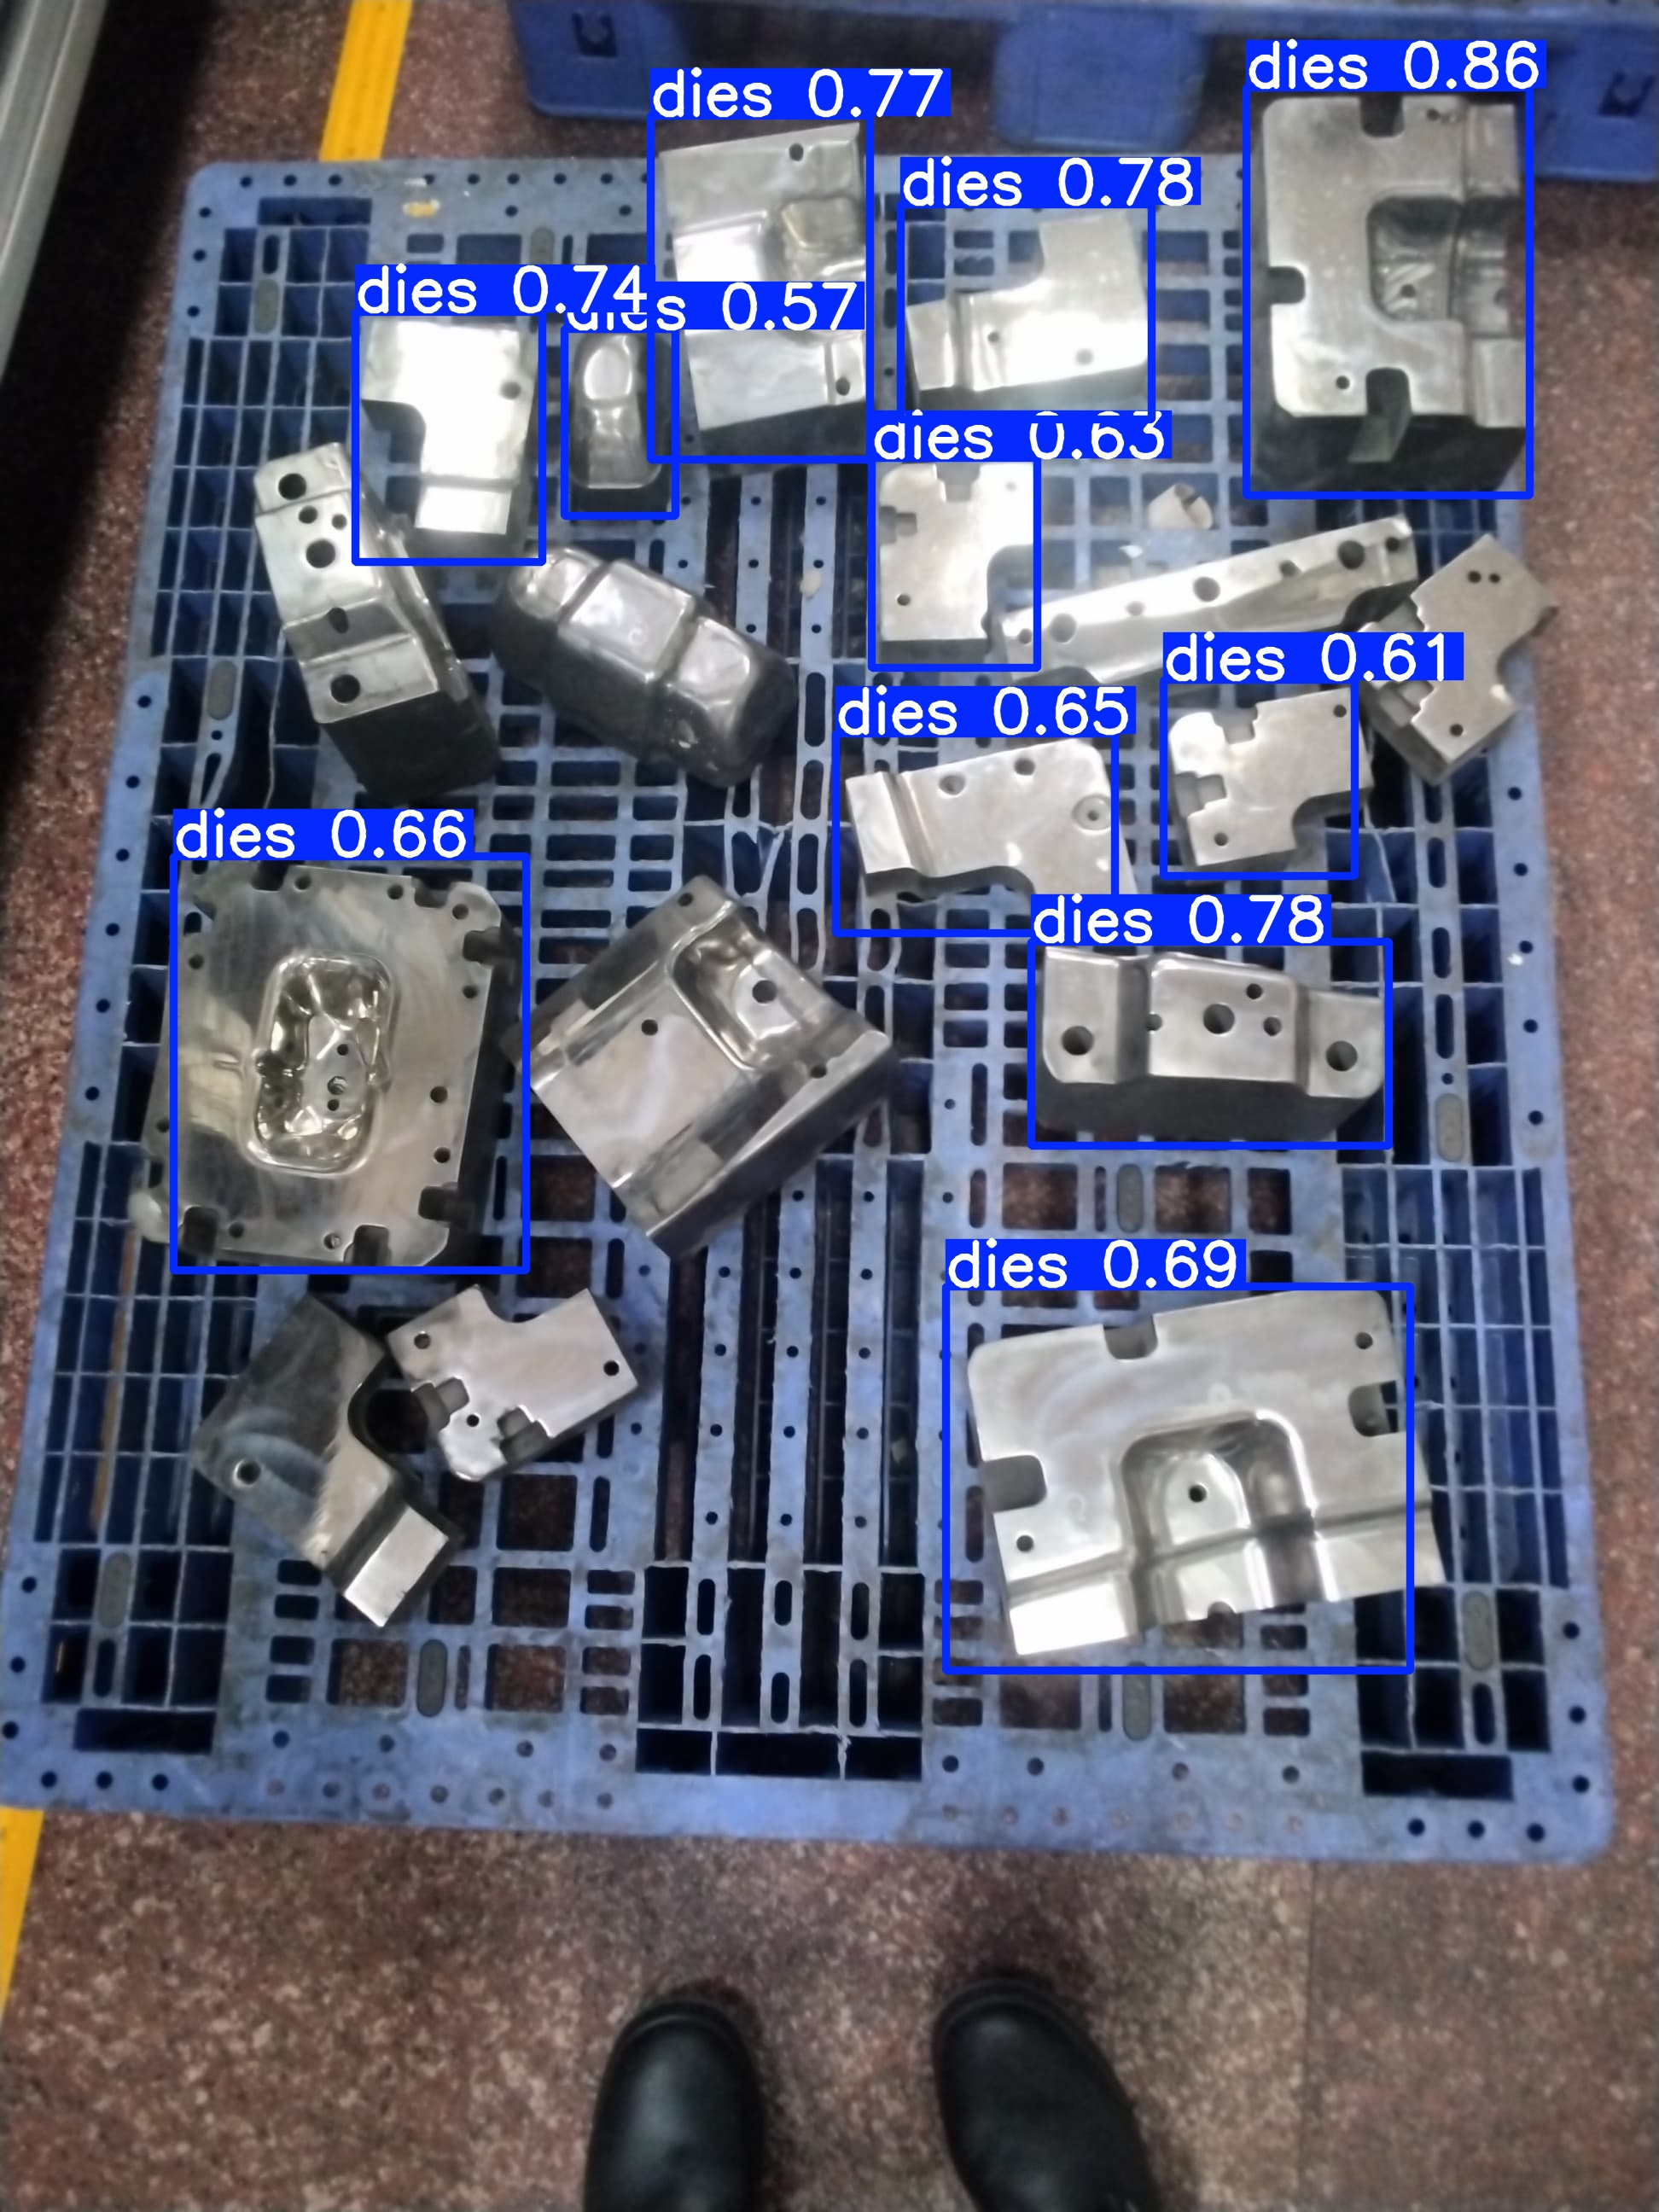

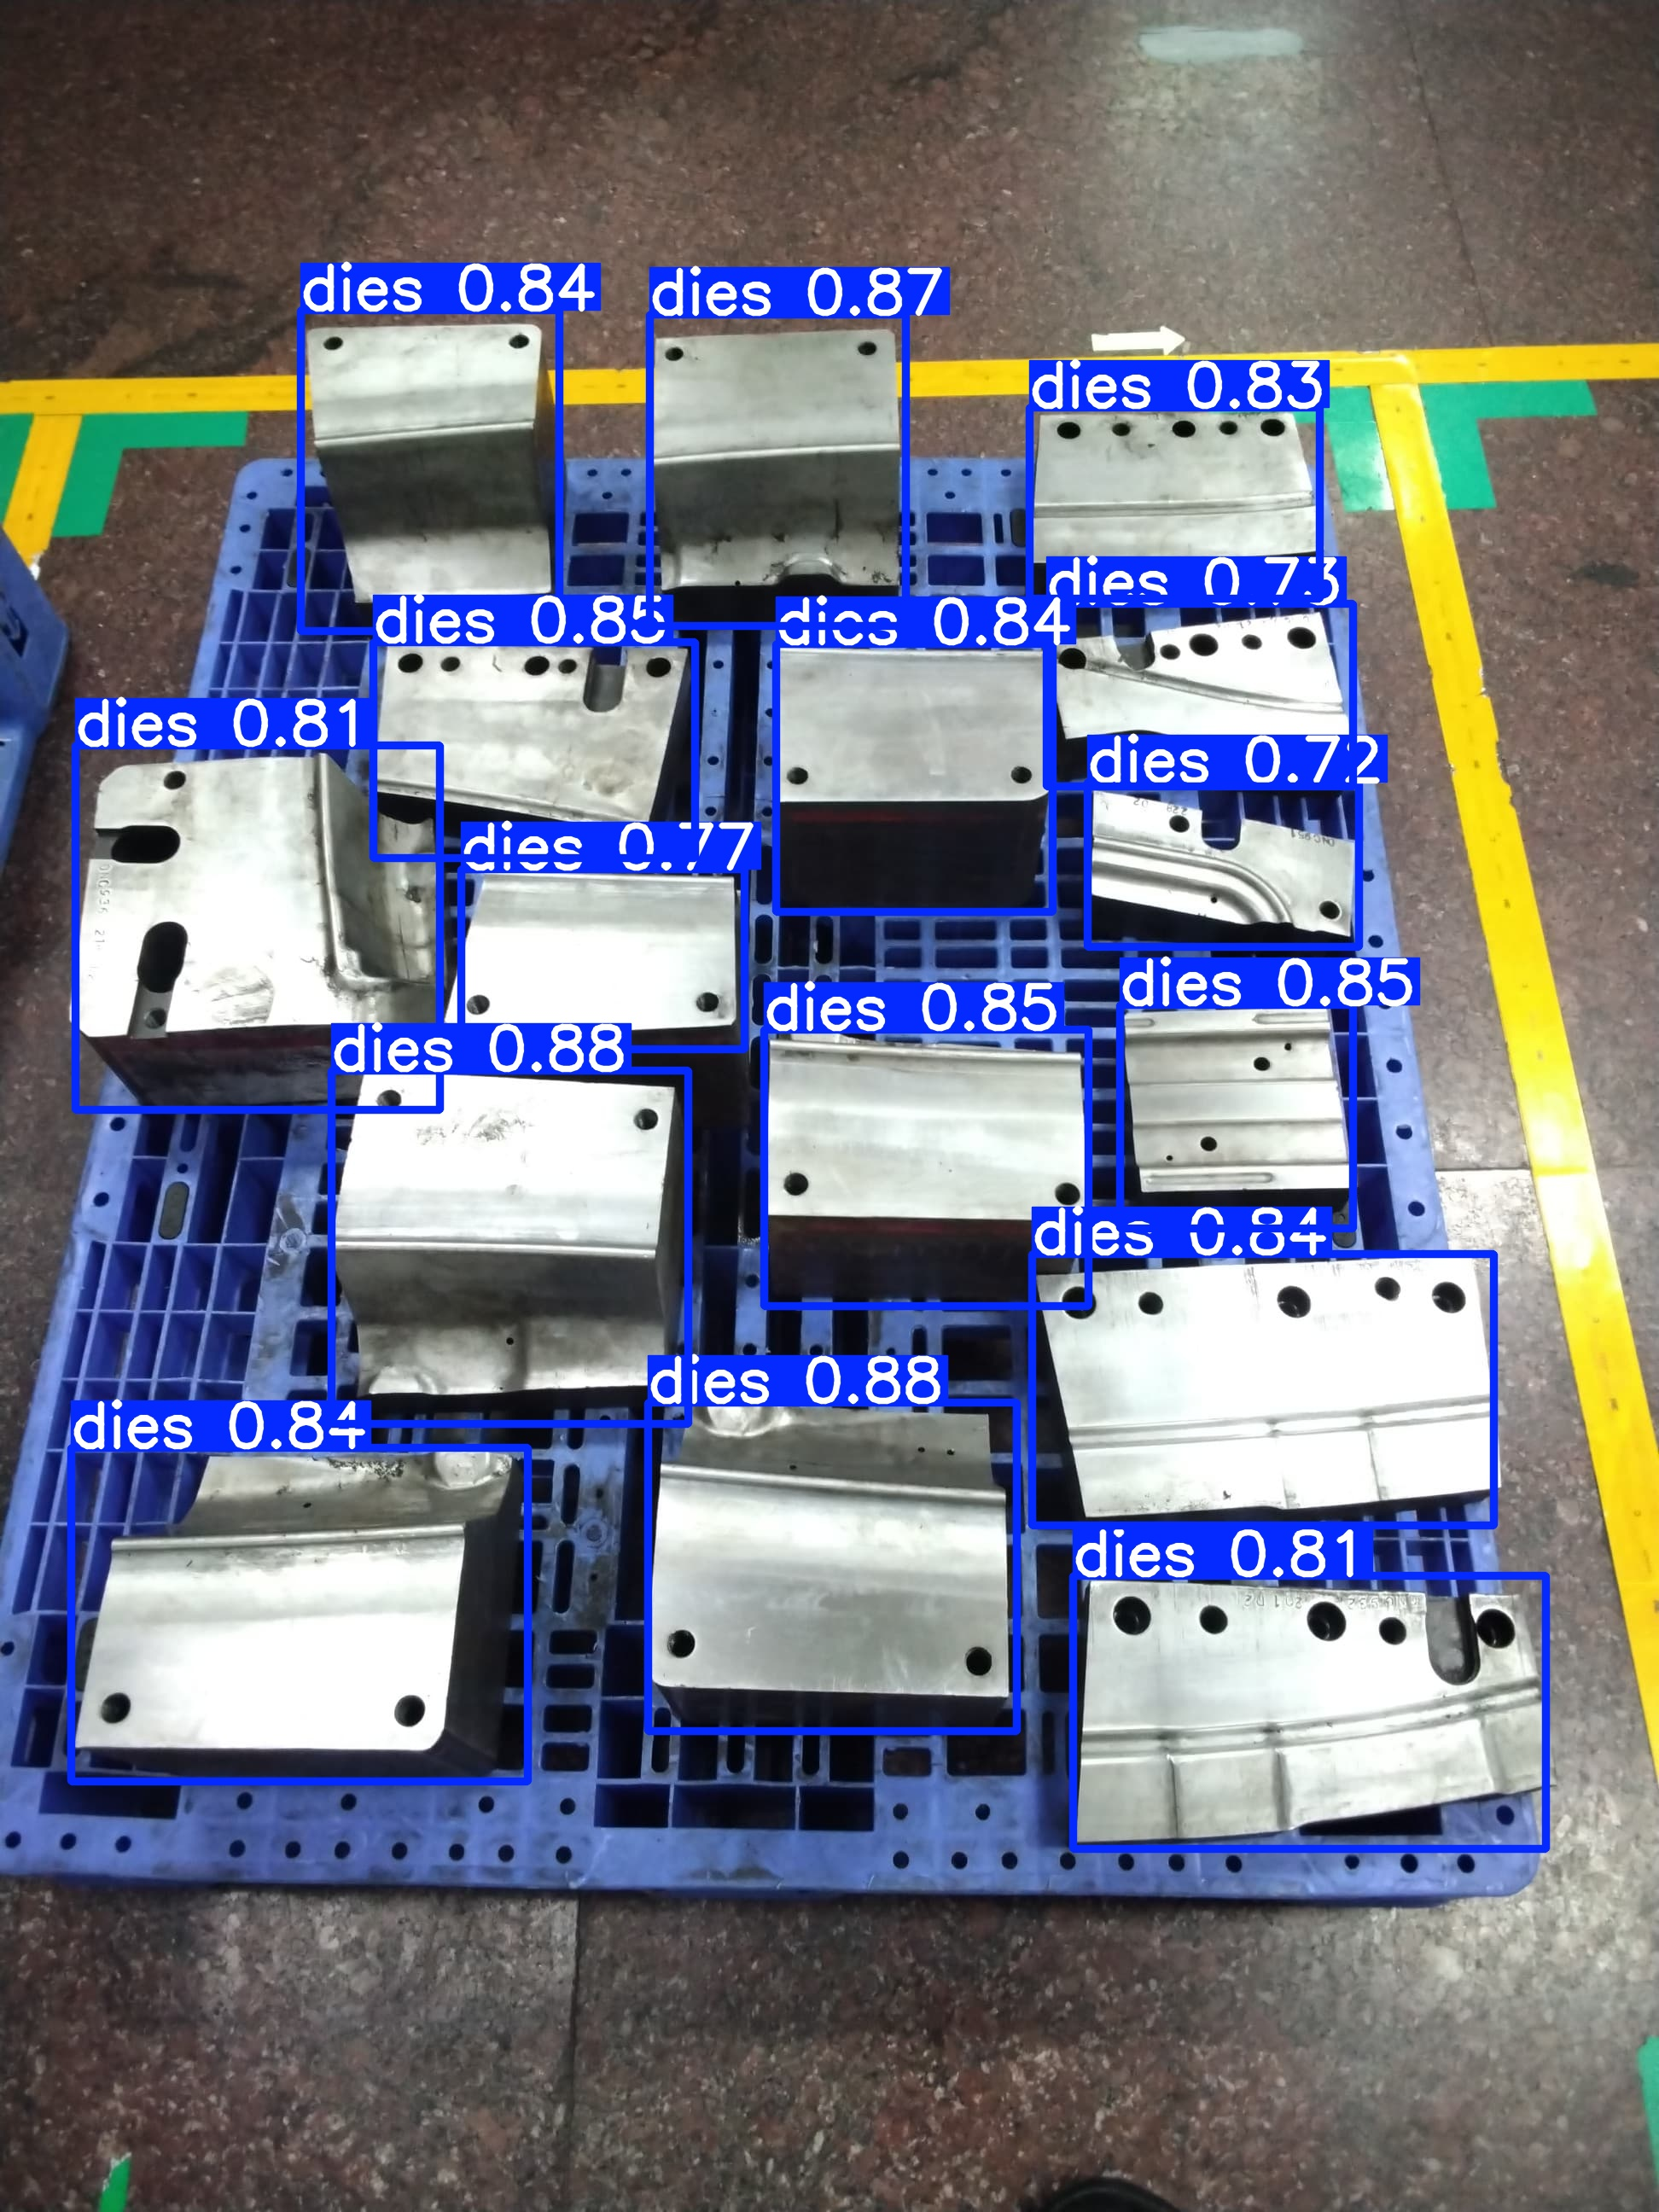

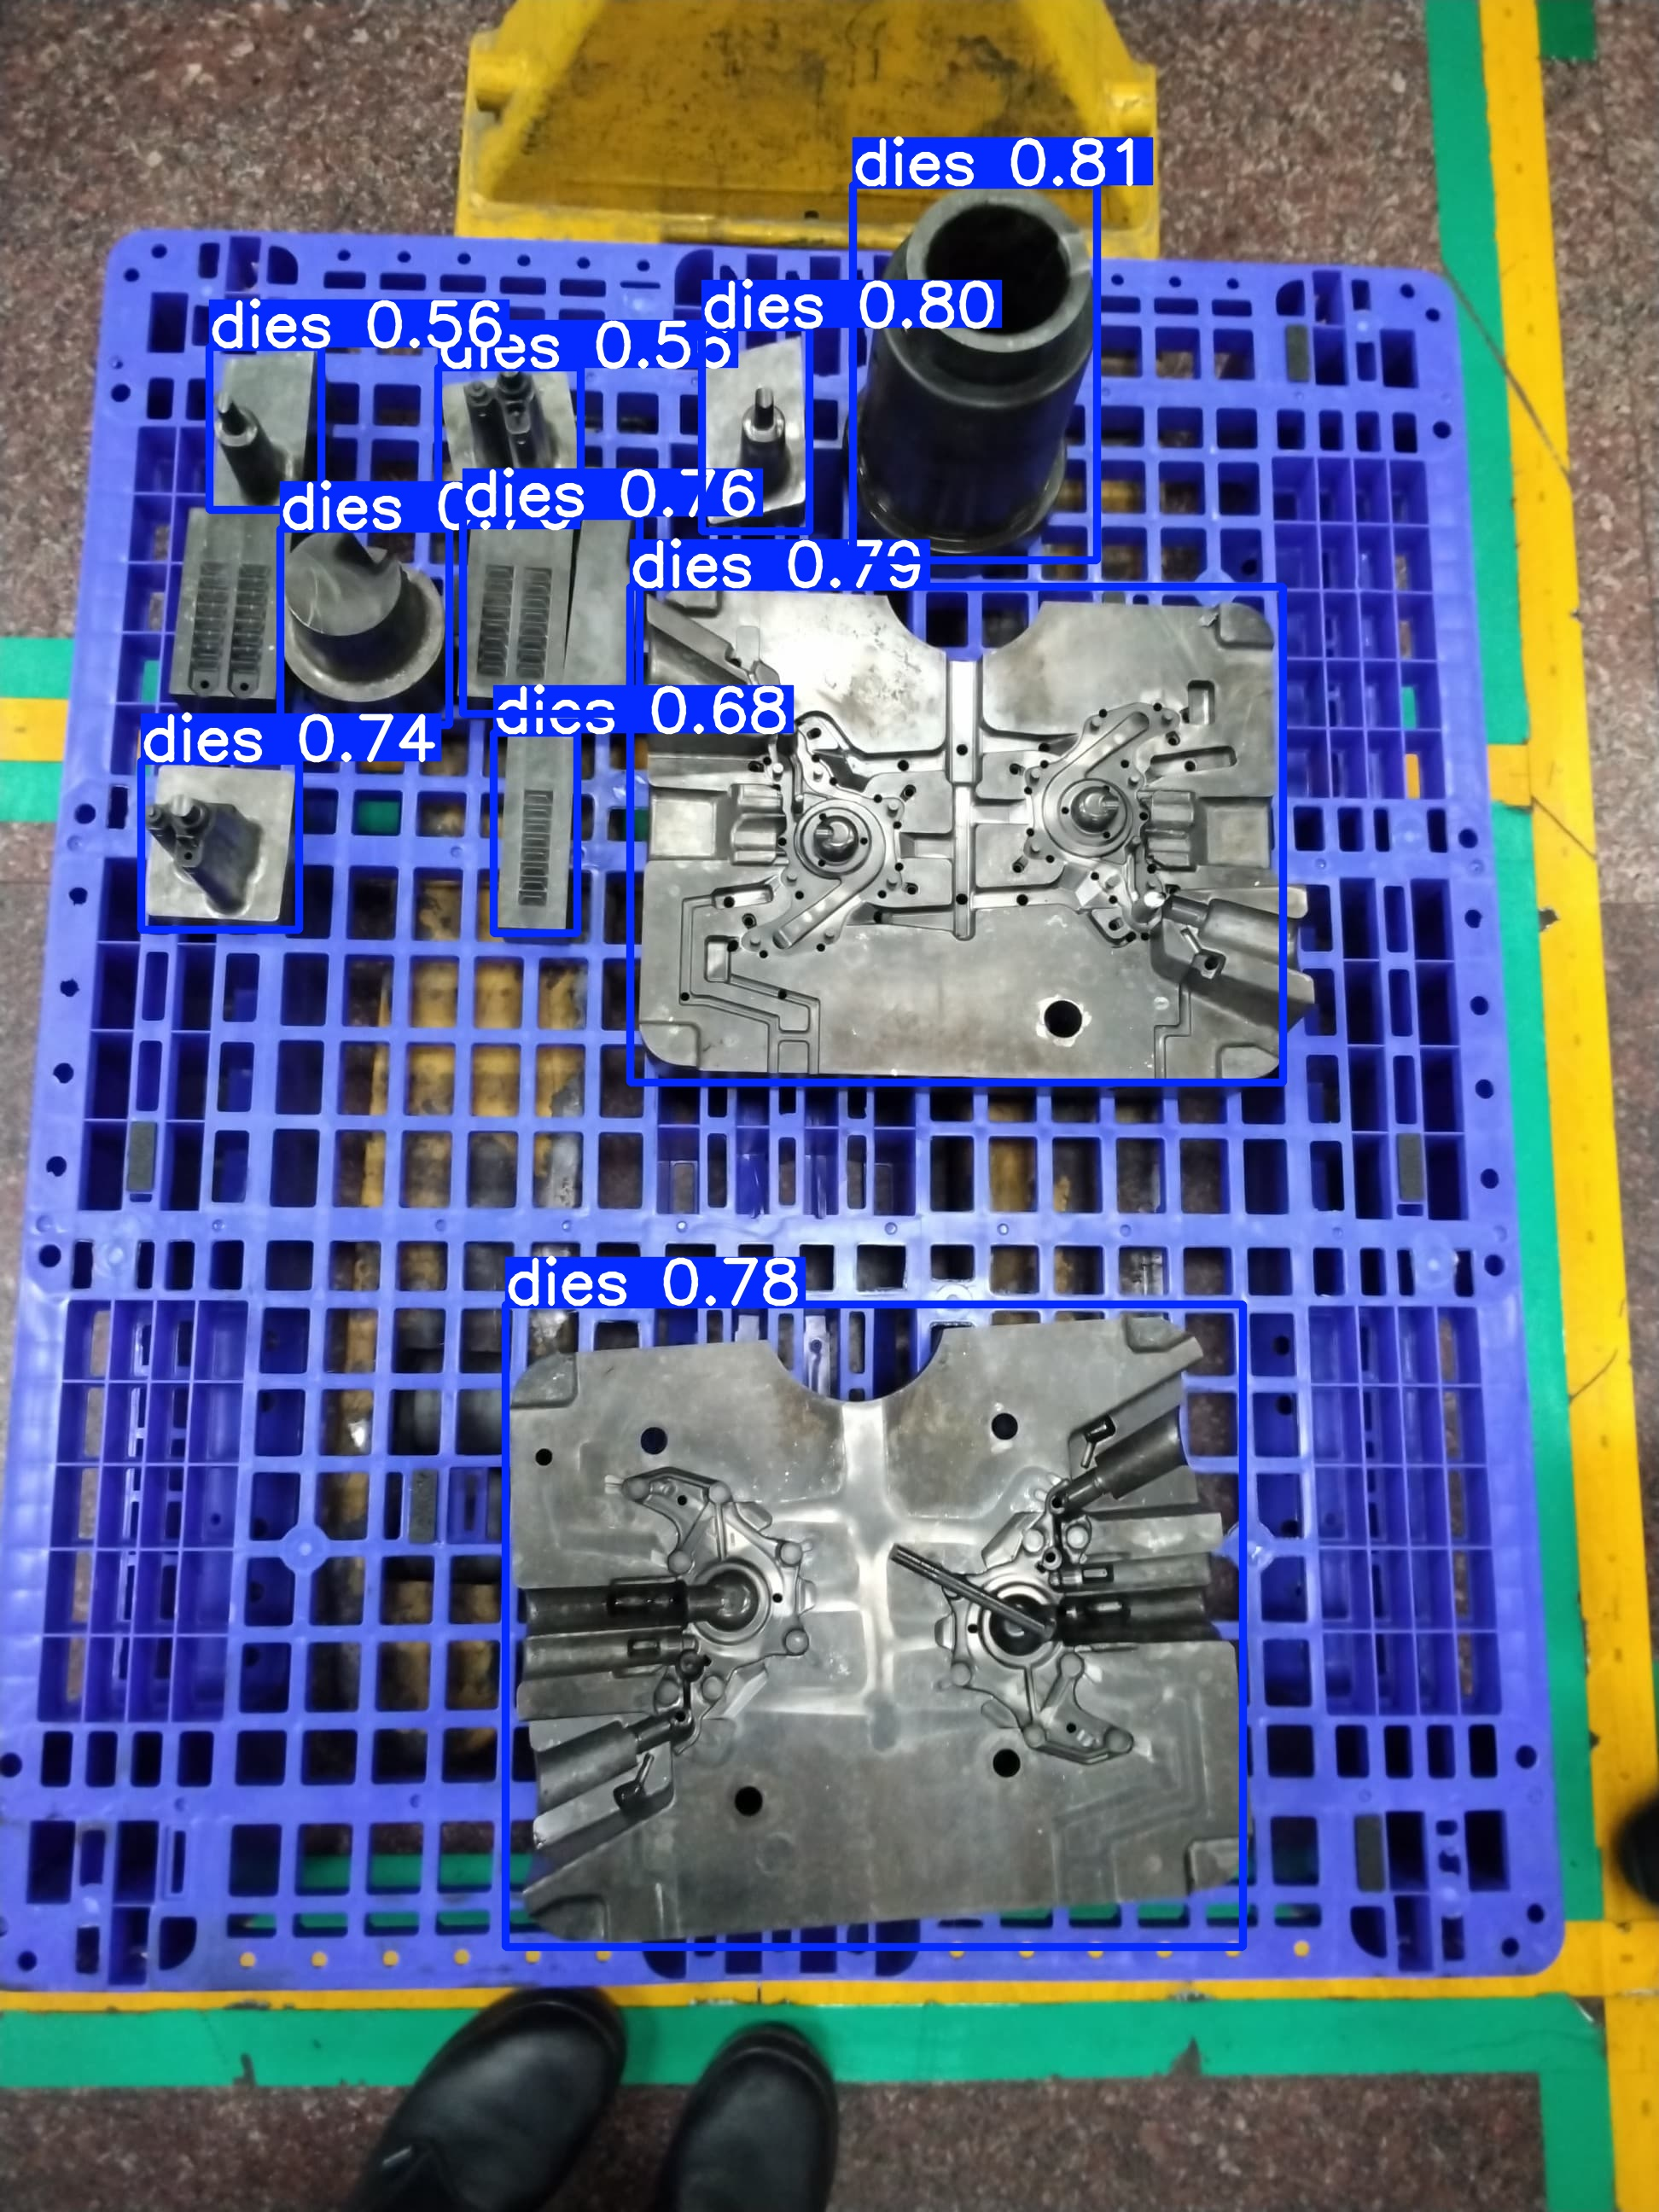

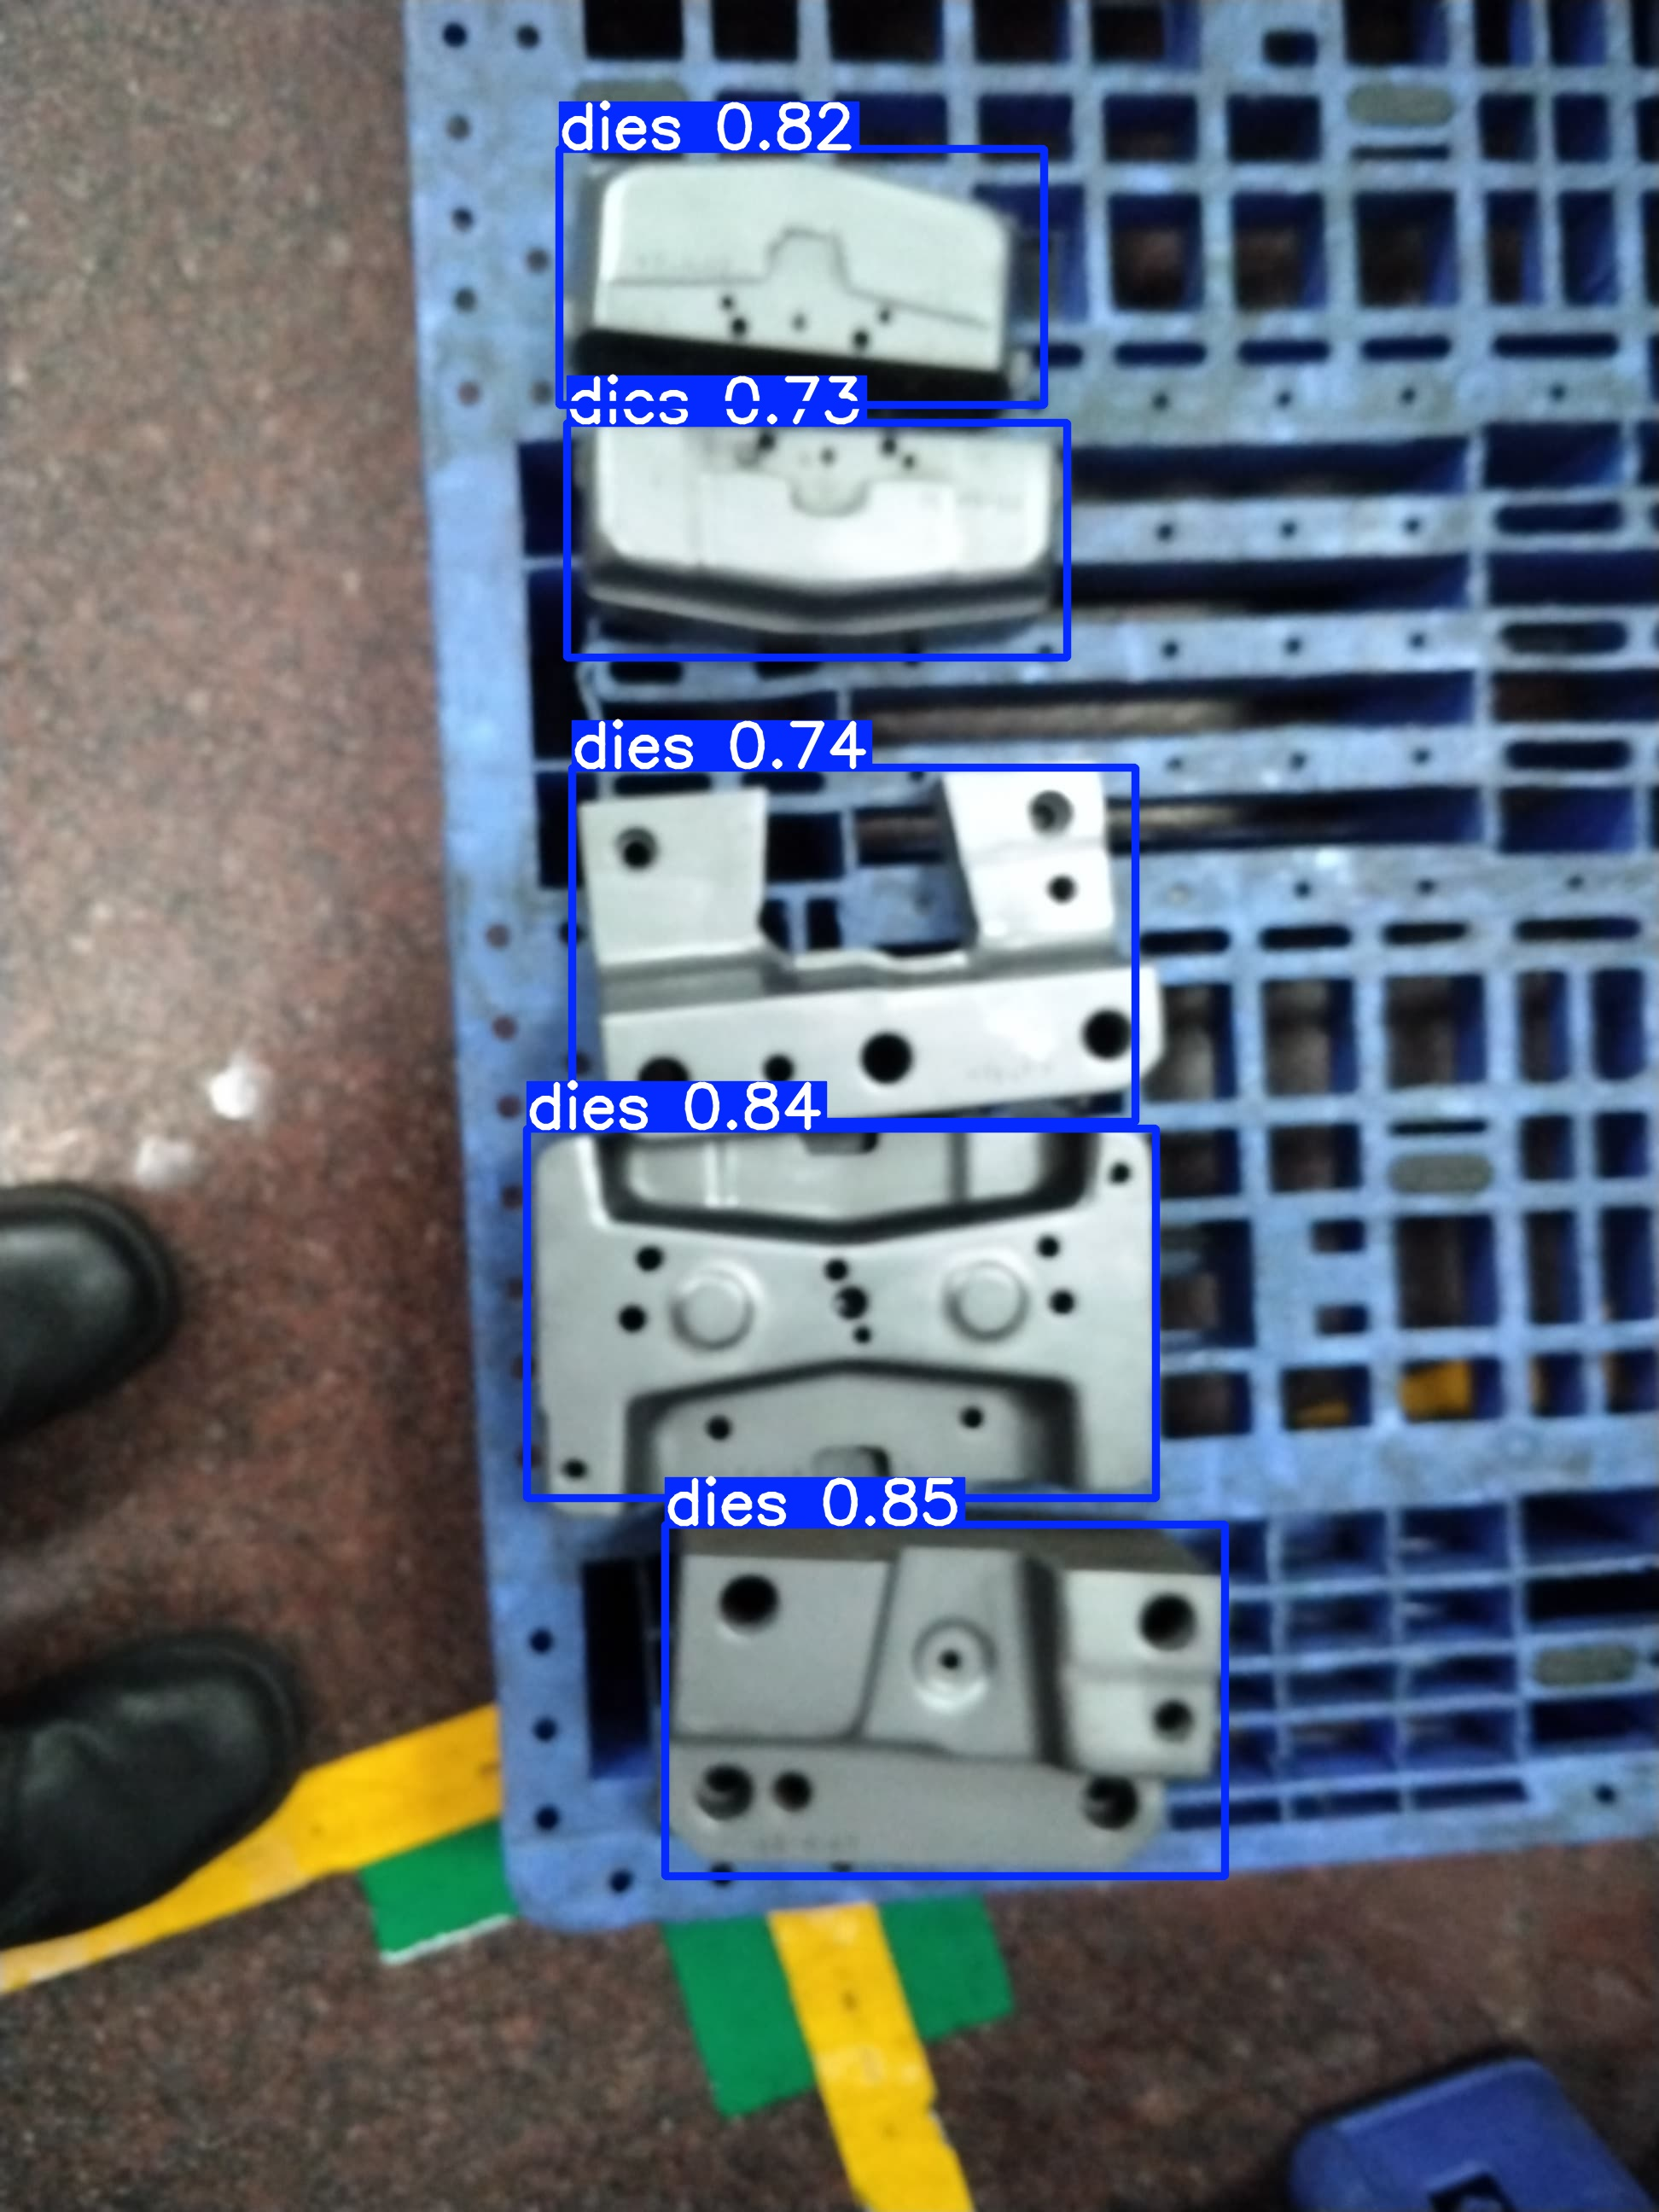

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')



image 1/4 /content/data/validation/images/0f5ddbc2-die_107.jpg: 640x480 5 diess, 13.1ms
image 2/4 /content/data/validation/images/4ecde482-die_52.jpeg: 640x480 16 diess, 12.4ms
image 3/4 /content/data/validation/images/b356d967-die_132.jpeg: 640x480 14 diess, 12.5ms
image 4/4 /content/data/validation/images/f6347e55-die_159.jpeg: 640x480 11 diess, 12.5ms
Speed: 3.1ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


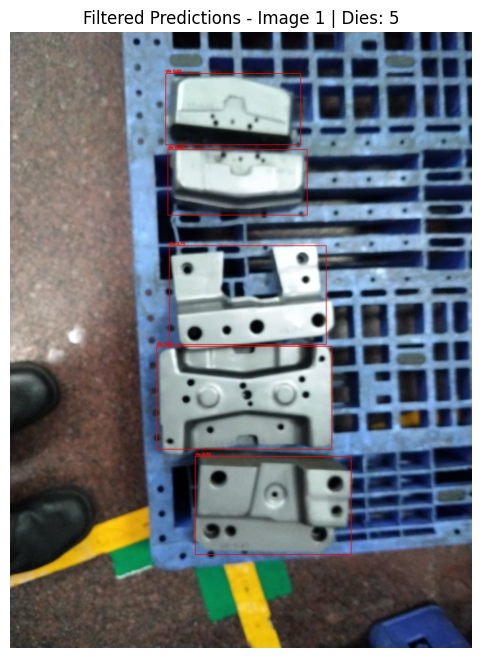

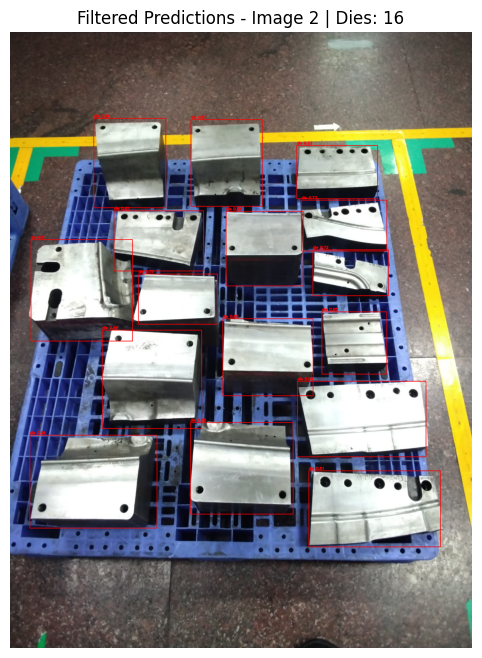

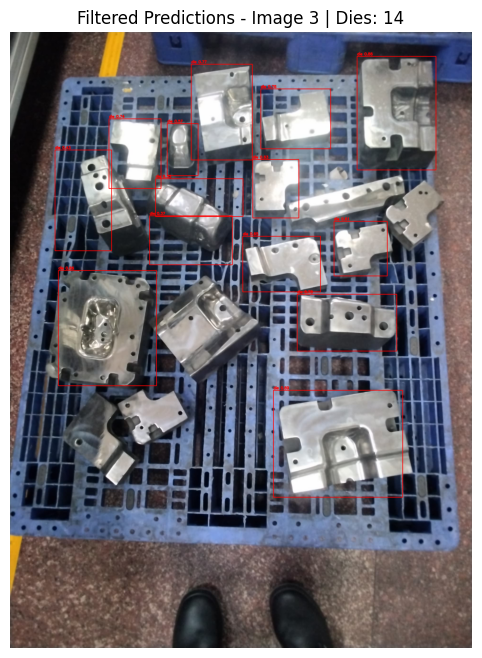

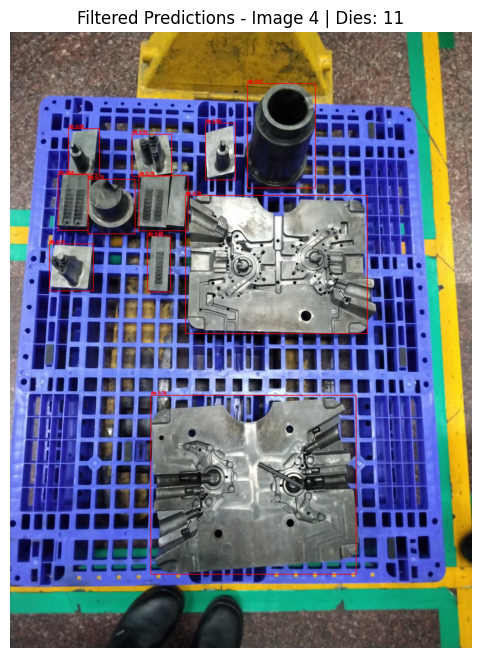

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

def remove_inner_boxes(boxes, scores):
    keep = []
    for i in range(len(boxes)):
        xi1, yi1, xi2, yi2 = boxes[i]
        is_inside = False
        for j in range(len(boxes)):
            if i == j:
                continue
            xj1, yj1, xj2, yj2 = boxes[j]
            if (xi1 >= xj1 and yi1 >= yj1 and xi2 <= xj2 and yi2 <= yj2):
                is_inside = True
                break
        if not is_inside:
            keep.append(i)
    return [boxes[i] for i in keep], [scores[i] for i in keep]

# Load YOLO model
model = YOLO("runs/detect/train/weights/best.pt")

# Predict on images
results = model.predict(source="/content/data/validation/images/", conf=0.25,iou=0.1 ,save=False)
#results = model.predict(source="/content/split_dataset/val/images/", conf=0.25,iou=0.1 ,save=False)
#results = model.predict(source="/content/die_129.jpeg", conf=0.55, save=False)

# Display results with matplotlib
for i, result in enumerate(results):
    img = result.orig_img.copy()
    boxes = result.boxes.xyxy.cpu().numpy().tolist()
    scores = result.boxes.conf.cpu().numpy().tolist()

    # Filter out inner boxes
    boxes, scores = remove_inner_boxes(boxes, scores)

    # Draw filtered boxes
    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(img, f'die {score:.2f}', (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show with matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Filtered Predictions - Image {i+1} | Dies: {len(boxes)}")
    plt.show()


In [ ]:
"""import glob
from IPython.display import Image, display
for image_path in glob.glob(f'data/validation/images*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')
"""

In [ ]:
"""model = YOLO("runs/detect/train7/weights/best.pt")
with torch.no_grad():
    results = model.predict(task="detect", source="data/validation/images", max_det=1000, conf=0.10, show_labels=True, show_conf=True, save=True, device="0")"""


image 1/3 /content/data/validation/images/2e415593-WhatsApp_Image_2025-05-22_at_2.06.38_PM2.jpeg: 640x480 8 diess, 19.6ms
image 2/3 /content/data/validation/images/a95a2dc2-WhatsApp_Image_2025-05-22_at_2.06.37_PM2.jpeg: 640x480 7 diess, 13.1ms
image 3/3 /content/data/validation/images/aeee0731-WhatsApp_Image_2025-05-22_at_2.06.39_PM.jpeg: 640x480 11 diess, 15.6ms
Speed: 4.8ms preprocess, 16.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict12


The model should draw a box around each die
 in each image.

In [ ]:
!pip install ultralytics MNN
!pip install -U aliyun-log-python-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 27.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.3/914.3 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.8 MB/s eta 0:00:00
  Created wheel for aliyun-log-python-sdk: filename=aliyun_log_python_sdk-0.9.24-py3-none-any.whl size=182823 sha256=92ca888808cfe588dbe3a42b49457191769fa01bcc9bca3d083601b6ab54c3ea
  Stored in directory: /root/.cache/pip/wheels/61/fd/b6/97448a023d798a98871faad63713e60b9454b31d5afe6625bf
Successfully built aliyun-log-python-sdk


In [ ]:
model.export(format="mnn")

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (18.3 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 5.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 8.0s, saved as 'runs/detect/train2/weights/best.onnx' (36.2 MB)

MNN: starting export with MNN 3.2.1...
MNN: export success ✅ 9.7s, saved as 'runs/detect/train2/weights/best.mnn' (36.1 MB)

Export complete (10.5s)
Results saved to /content/runs/detect/train2/

'runs/detect/train2/weights/best.mnn'

# 8.&nbsp;Conclusion

This software can be used to count the number of dies on the shopfloor to ensure save valuable man hours